# How to use the massbalance-sandbox for intercomparison of different mass balance types in OGGM


- so far, only applied to single elevation flowlines of Huss
- more detailed analysis can be found in ./intercomparison_w_figures

In [2]:
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  

from functools import partial
import shutil
import copy
import time
import numpy as np
import pandas as pd
from numpy.testing import assert_allclose
import scipy
from scipy.stats import linregress
import os
import pytest
import matplotlib.pyplot as plt
import xarray as xr
import oggm

# imports from OGGM
from oggm.core import massbalance
from oggm import utils, workflow, tasks, cfg
from oggm.cfg import SEC_IN_DAY, SEC_IN_YEAR, SEC_IN_MONTH
from oggm.core import massbalance

from oggm.exceptions import InvalidWorkflowError, InvalidParamsError


# imports from MBsandbox package modules
from MBsandbox.mbmod_daily_oneflowline import process_era5_daily_data, TIModel, BASENAMES
from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

In [3]:
# get larger figures
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('figure',figsize=(20,10))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
cfg.initialize()

working_dir = '/home/lilianschuster/Schreibtisch/PhD/oggm_files/oneFlowline'
# this needs to be changed if working on another computer
if not os.path.exists(working_dir):
    working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)
    
cfg.PATHS['working_dir'] = working_dir
# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

2021-02-23 17:48:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-23 17:48:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-23 17:48:45: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-23 17:48:45: oggm.utils: Checking the download verification file checksum...


we use here the Hintereisferner as example, but any other Alpine WGMS reference glacier could be chosen instead:
- first get glacier directory


In [5]:
# get HEF glacier
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                  prepro_base_url=base_url,
                                  prepro_rgi_version='62')
gd = gdirs[0]
h, w = gd.get_inversion_flowline_hw()
fls = gd.read_pickle('inversion_flowlines')

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-02-23 17:48:47: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-02-23 17:48:47: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-23 17:48:47: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar


- define climate (here ERA5) and get reference mass balance data
- choose an arbitrary temperature melt factor melt_f (DDF, mu_star, ) [melt_f is optimised later]
- and choose how the degree days should be computed:

  if ***'ERA5dr'*** as baseline_climate:
    > cfg.PARAMS['baseline_climate'] = 'ERA5dr'
      oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
    - using monthly temperatures: mb_type=***'mb_monthly'***
        (default in OGGM)
    - using monthly temperatures and daily temp std to generate daily temp. assuming normal distributed data: mb_type=***'mb_daily'***
    
  if ***'ERA5_daily'*** as baseline_climate:
     > cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
      process_era5_daily_data(gd)
    - using "real" daily temperatures, those from ERA5: mb_type=***'mb_real_daily'***
  
  in addition choose how the temperature should be downscaled to the right elevation:
    - using a constant calibrated value independent of location and season, default is -6.5 K/km: grad_type=***'cte'***
        (default in OGGM)
    - using lapse rates from ERA5 that vary throughout the year and inbetween glacier locations, but that are constant inbetween the years: grad_type=***'var_an_cycle'***
        (similar as in PyGEM, GloGEM)
    - using a seasonally and for each glacier location changing lapse rate, derived from ERA5, different for each year: grad_type=***'var'***
        (default if OGGM with ERA5dr is used in PastMassBalance)
  

In [14]:
# if I use ERA5dr in PastMassBalance, it applies automatically the
# gradient that changes with time and location (corresponds to option 'var' in grad_type)
cfg.PARAMS['baseline_climate'] = 'ERA5'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5')
# cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
# process_era5_daily_data(gd)
mbdf = gd.get_ref_mb_data()

# arbitrary degree day factor
melt_f = 200
# this is just the default mass balance option from OGGM
mb_type = 'mb_monthly'  # could here use mb_daily or mb_real_daily (but would need to adapt the climate)
grad_type = 'cte'       # could here also use 'var_an_cycle' or 'var'
gd_mb = TIModel(gd, melt_f, mb_type=mb_type, grad_type=grad_type)
# check if the glacier melts and accumulates at least for 3 months over one gridpoint per year
# and otherwise adapt the ref_hgt
gd_mb.historical_climate_qc_mod(gd)
mb_specific = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)

# choose the same parameters as in default TIModel
cfg.PARAMS['temp_default_gradient'] = -0.0065
cfg.PARAMS['prcp_scaling_factor'] = 2.5
cfg.PARAMS['temp_all_solid'] = 0
cfg.PARAMS['temp_all_liq'] = 2
cfg.PARAMS['temp_melt'] = 0
gd_mb_default = massbalance.PastMassBalance(gd, mu_star=melt_f,
                                            bias=0, check_calib_params=False)
mb_specific_default = gd_mb_default.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-02-23 17:50:40: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5`.
2021-02-23 17:50:40: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


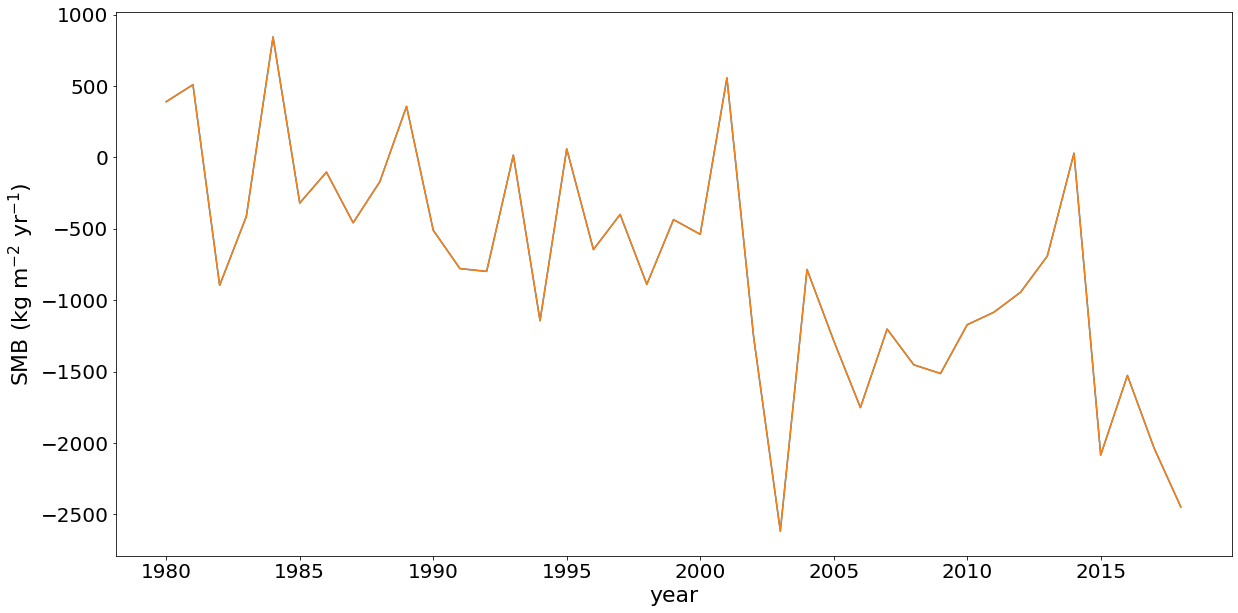

In [15]:
plt.plot(mbdf.index, mb_specific)
plt.plot(mbdf.index, mb_specific_default)

plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');

as we can see, both, the default massbalance.PastMassBalance and TIModel with 'mb_monthly' and 'cte give the same results

In [16]:
# always the same pre-defined gradient 
np.all(gd_mb.grad == -0.0065)

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [17]:
# gradients are the same
np.all(gd_mb.grad == gd_mb_default.grad)

True

Let's now use the ERA5dr dataset again!

In [24]:
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
gd_mb = TIModel(gd, melt_f, mb_type='mb_monthly', grad_type='var_an_cycle')


2021-02-23 17:54:29: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


and compute the optimal melt factor that minimises the bias 

In [25]:
melt_f_opt = scipy.optimize.brentq(minimize_bias,1,10000, args=(gd_mb, gd, 
                                                             2.5, False), disp=True, xtol=0.1) 

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
melt_f_opt

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


195.32280341252496

**an other example**

In [27]:
# use the ERA5 dataset with daily temperature resolution and the related mb_real_daily option for the mass balance
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_era5_daily_data(gd)
mbdf = gd.get_ref_mb_data()

# arbitrary degree day factor
melt_f = 200
# this is just the default mass balance option from OGGM
mb_type = 'mb_real_daily'  # could here use mb_daily or mb_real_daily (but would need to adapt the climate)
grad_type = 'var_an_cycle'       # could here also use 'var_an_cycle' or 'var'
gd_mb = TIModel(gd, melt_f, mb_type=mb_type, grad_type=grad_type)
# check if the glacier melts and accumulates at least for 3 months over one gridpoint per year
# and otherwise adapt the ref_hgt
gd_mb.historical_climate_qc_mod(gd)
mb_specific = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)


2021-02-23 17:54:54: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 17:54:54: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
2021-02-23 17:54:56: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/daily/v1.0/era5_daily_t2m_1979-2018_flat.nc verified successfully.
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
2021-02-23 17:54:56: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/daily/v1.0/era5_glacier_invariant_flat.nc verified successfully.
/home/lilianschust

In [28]:
# gradient changes throughout the year and is not the same as the predefined one
gd_mb.grad

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([-0.00562016, -0.00562016, -0.00562016, ..., -0.00555807,
       -0.00555807, -0.00555807], dtype=float32)

In [29]:
# but the gradient is the same for each year in case of 'var_an_cycle'
np.all(gd_mb.grad[0:12] == gd_mb.grad[12:24])

True

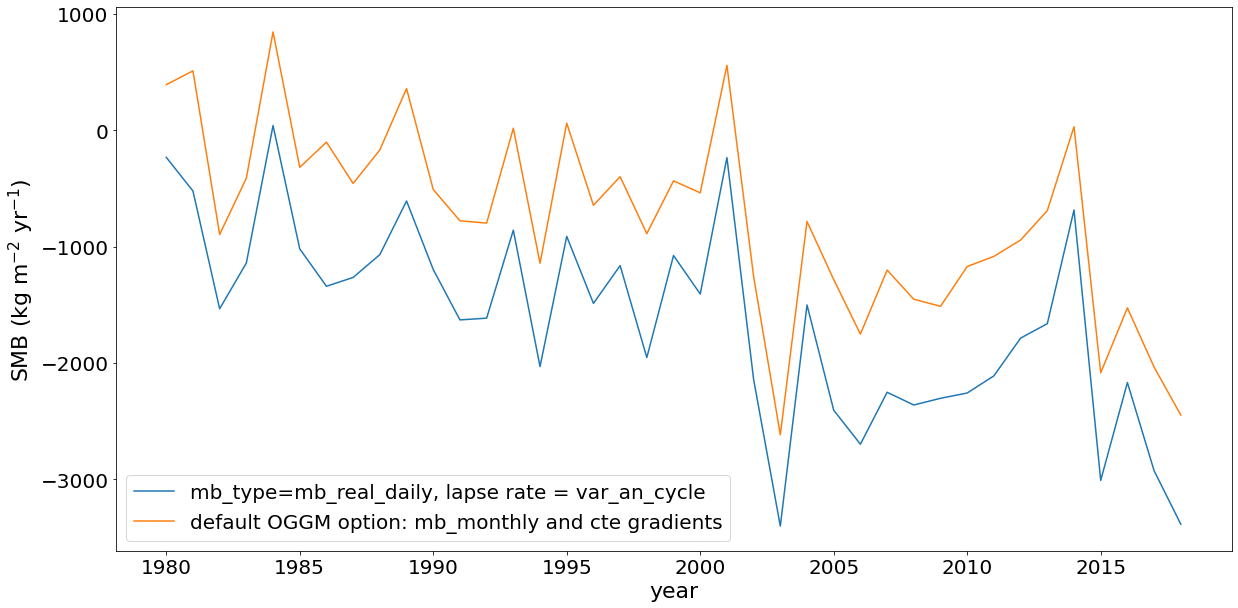

In [30]:
plt.plot(mbdf.index, mb_specific, label = 'mb_type={}, lapse rate = {}'.format(mb_type, grad_type))
plt.plot(mbdf.index, mb_specific_default, label = 'default OGGM option: mb_monthly and cte gradients')

plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');
plt.legend()

- when using the same melt_f for two different mb type options, different results come out, because the sensitivity by the use of daily temperatures and lapse rate is different
- therefore, each model has to be calibrated individually to compare them 

# We can now compare different options by optimising the melt_f for each MB model type
- the optimisation is done by minimising the bias 


In [35]:
co = ['green','lightgreen','blue','lightblue','red', 'orange']
loop = False
def plot_mb(gd, mb_type = 'mb_monthly', grad_type = 'cte', N = 100, pf = 2.5 , co ='r'):
    """ plots modelled mb time series optimized by minimising the bias with performance statistics as labels """

    gd_mb = TIModel(gd, None, prcp_fac = pf, mb_type=mb_type, grad_type=grad_type, N = N, loop = loop)
    melt_f_opt = scipy.optimize.brentq(minimize_bias,1,10000, args=(gd_mb, gd, 
                                                             2.5, False), disp=True, xtol=0.1) 
    gd_mb.melt_f = melt_f_opt
    # check if the glacier melts and accumulates at least for 3 months over one gridpoint per year
    # and otherwise adapt the ref_hgt
    gd_mb.historical_climate_qc_mod(gd)
    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
    RMSD, bias , rcor, quot_std = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
    plt.plot(mbdf.index, mb_specific, color = co,
             label = 'modeled {} {} gradient: RMSD {}, rcor {}, std_quot {}, bias {}'.format(mb_type, grad_type,
                                                                                             RMSD.round(1), rcor.round(3), quot_std.round(3), bias.round(2), ))

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- remember that we need to prescribe the right climate for the right mass balance type!

2021-02-23 17:57:53: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 17:57:54: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 17:57:54: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instea

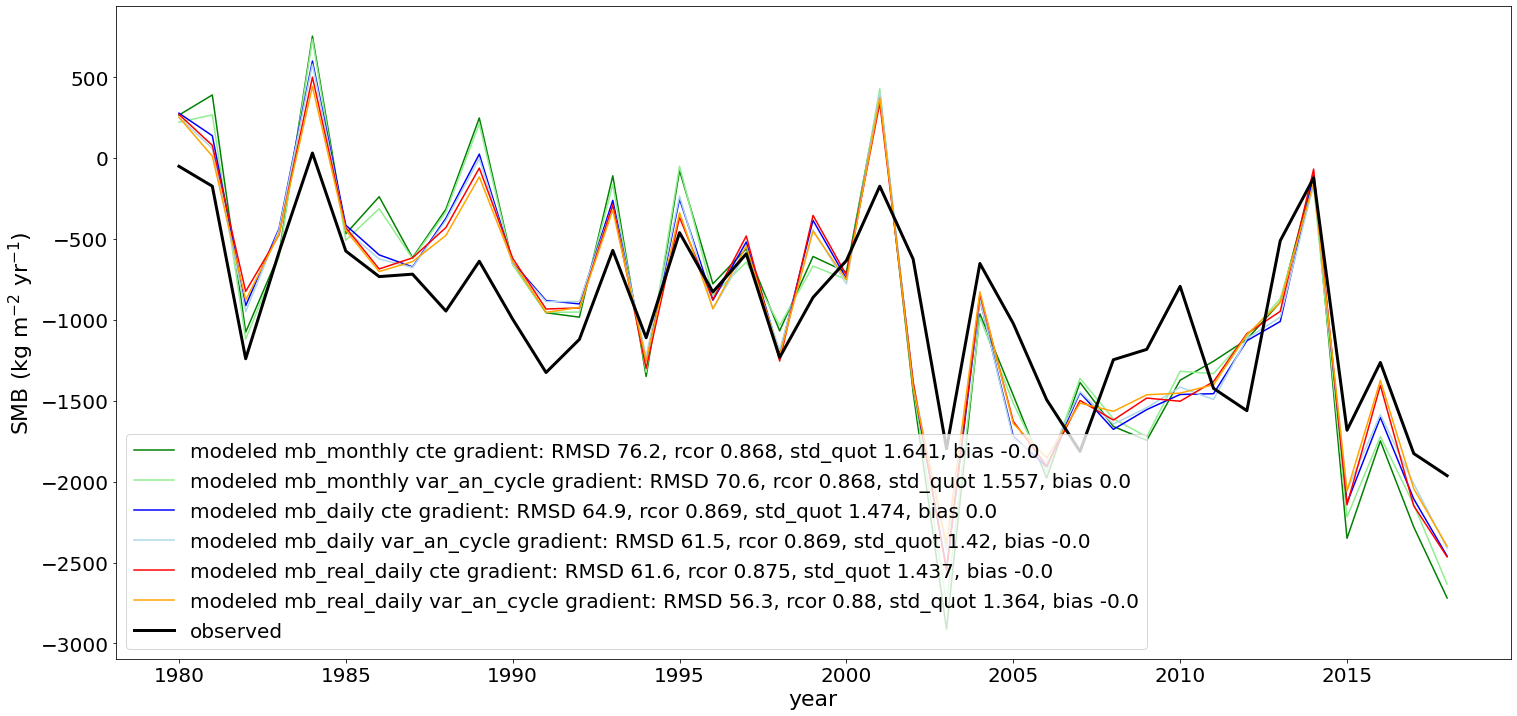

In [36]:
plt.figure(figsize=(25,12))
# for mb_monthly and mb_daily: use ERA5dr climate!
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
j = 0
for mb_type in [ 'mb_monthly','mb_daily']:
    
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j]  )
        j += 1

# for mb_real_daily: use ERA5_daily climate!
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_era5_daily_data(gd)

for mb_type in ['mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j] )
        j +=1


plt.plot(mbdf.index,
         mbdf.ANNUAL_BALANCE,
         label = 'observed', color = 'black', lw=3)
plt.legend()
plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');
plt.savefig('./intercomparison_w_figures/figures_hef/HEF_mb_time_series_mod_obs_6types.pdf')
